# <a id='toc1_'></a>[Forecsting remainders with OLS](#toc0_)

## <a id='toc1_1_'></a>[Libraries](#toc0_)

In [1]:
#install.packages("C:/Users/madsh/Downloads/path/to/withr_2.1.2.tar.gz", repos = NULL, type = "source")

#install.packages('forecast')
#install.packages('doParallel')
#install.packages('xgboost')

library(tidyverse)
library(forecast)
library(dplyr)
library(data.table)
library(IRdisplay)

library(ggplot2)
library(patchwork)

library(foreach)
library(doParallel)

library(caret)
library(randomForest)
library(xgboost)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Vedhæfter pakke: 'data.table'


De følgende objekter er maskerede fra 'package:lubridate':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


De følgende objekter er maskerede fra 'package:dplyr':

    between, first, last


Det følgende objekt er maskeret fra 'package:purrr':

    transpose



Vedhæfter pakke: 'foreach'


De følgende obj

## <a id='toc1_2_'></a>[Custom functions](#toc0_)

### <a id='toc1_2_1_'></a>[Display tables](#toc0_)

In [2]:
# Custom display function for the first and last 5 rows or full table if <= 20 rows
display_limited <- function(dt) {
  n <- nrow(dt)
  
  # If there are 20 or fewer rows, display the full table
  if (n <= 20) {
    limited_dt <- dt
  } else {
    # Otherwise, concatenate the first 5 rows, '...' and the last 5 rows
    limited_dt <- rbind(head(dt, 5), as.list(rep("...", ncol(dt))), tail(dt, 5))
  }
  
  # Generate raw HTML manually
  html_output <- paste0(
    "<table border='1' style='border-collapse:collapse;'>",
    "<thead><tr>",
    paste0("<th>", colnames(limited_dt), "</th>", collapse = ""),
    "</tr></thead>",
    "<tbody>",
    paste0(
      apply(limited_dt, 1, function(row) {
        paste0("<tr>", paste0("<td>", row, "</td>", collapse = ""), "</tr>")
      }),
      collapse = ""
    ),
    "</tbody></table>"
  )
  
  # Display the HTML in the Jupyter notebook
  display_html(html_output)
}


### <a id='toc1_2_2_'></a>[Calculate metrics](#toc0_)

In [3]:
calculate_metrics <- function(T_t, R_hat_t, individual) {
  # Ensure the inputs are numeric vectors and individual is a dataframe
  if (!is.numeric(T_t) || !is.numeric(R_hat_t)) {
    stop("Both T_t and R_hat_t need to be numeric vectors.")
  }
  
  # Calculate metrics
  mae <- mean(abs(T_t - R_hat_t), na.rm = TRUE)
  rmse <- sqrt(mean((T_t - R_hat_t)^2, na.rm = TRUE))
  mape <- mean(abs((T_t - R_hat_t) / T_t), na.rm = TRUE) * 100
  r_squared <- ifelse(all(T_t == R_hat_t), 1, summary(lm(T_t ~ R_hat_t))$r.squared)
  
  # Create a data frame to hold the metrics and values
  metrics_table <- data.frame(
    MAE = mae,
    RMSE = rmse,
    MAPE = mape,
    R_squared = r_squared
  )
  
  # Return the metrics table
  return(metrics_table)
}

### <a id='toc1_2_3_'></a>[Data Preparation](#toc0_)

In [4]:
prepare_X_t <- function(individual) {
  # Ensure the input is a dataframe
  if (!is.data.frame(individual)) {
    stop("The input must be a dataframe.")
  }
  
  # Extract hour from start_time and create a 'time_of_day' column
  individual$time_of_day <- format(as.POSIXct(individual$HourDK), "%H:%M:%S")
  
  # Exclude specified columns but keep 'time_of_day'
  X_t <- subset(individual, select = -c(HourDK, GrossConsumptionMWh))
  
  # Convert month, weekday, and time_of_day to factors with a reference category
  X_t$month <- relevel(as.factor(X_t$MonthOfYear), ref = "December")  # Set December as reference
  X_t$weekday <- relevel(as.factor(X_t$DayOfWeek), ref = "Sunday")   # Set Sunday as reference 
  X_t$time_of_day <- relevel(as.factor(X_t$Hour), ref = "0")         # Set 23 (11 PM) as reference

  # Remove original 'MonthOfYear', 'DayOfWeek', and 'Hour' columns to avoid duplication
  X_t <- subset(X_t, select = -c(MonthOfYear, DayOfWeek, Hour))
  
  # Create dummy variables for all factor columns (excluding reference levels)
  X_t <- model.matrix(~ . - 1, data = X_t)
  
  # Find the column indices for numerical columns AFTER creating dummy variables
  num_cols <- grep("^(Electric cars|Plug-in hybrid cars|humidity_past1h|temp_mean_past1h|wind_speed_past1h|EL_price)", colnames(X_t))
  
  # Standardize selected numerical columns
  X_t[, num_cols] <- apply(X_t[, num_cols], 2, 
                           function(x) (x - min(x)) / (max(x) - min(x)))
  
  # Return the processed dataframe
  return(as.data.frame(X_t))
}


### <a id='toc1_2_4_'></a>[Lag and Align data by \\(h\\) (horizon)](#toc0_)

In [5]:
lag_and_align_data <- function(X_t, R_t, h = 1) {
  # Validate inputs
  if (!is.numeric(R_t)) {
    stop("R_t should be a numeric vector.")
  }
  if (!is.data.frame(X_t) && !is.matrix(X_t)) {
    stop("X_t should be a dataframe or a matrix.")
  }
  if (!is.numeric(h) || h < 1) {
    stop("h should be a positive integer.")
  }
  
  # Convert X_t to a dataframe if it's a matrix
  if (is.matrix(X_t)) {
    X_t <- as.data.frame(X_t)
  }
  
  # Align R_t with the lagged X_t
  # Shift R_t by h positions to align with X_t from the previous timestep
  R_t_aligned <- R_t[(h + 1):length(R_t)]
  
  # Keep X_t up to the second to last row, so it aligns with the shifted R_t
  X_t_aligned <- X_t[1:(nrow(X_t) - h), ]
  
  # Return the aligned datasets
  list(X_t = X_t_aligned, R_t = R_t_aligned)
}

### <a id='toc1_2_5_'></a>[Plot actual vs estimated](#toc0_)

In [6]:
plot_actual_vs_estimated <- function(R_t, R_hat_t, individual) {
  # Validate input
  if (!is.numeric(R_t) || !is.numeric(R_hat_t)) {
    stop("R_t and R_hat_t should be numeric vectors.")
  }
  if (!is.data.frame(individual)) {
    stop("individual should be a dataframe.")
  }
    
  # Create the plot
  plot(R_t, type = 'l', col = 'blue', xlab = "Time", ylab = "Value", 
       main = "Actual vs. Estimated Time Series\nelvarme: %s, zip_code: %s")
  lines(R_hat_t, type = 'l', col = 'red')
  legend("topleft", legend = c("Actual", "Estimated"), col = c("blue", "red"), lty = 1)
}

## <a id='toc1_3_'></a>[Loading data](#toc0_)

In [7]:
##### Setting workign directory and loadign data #####
base_path <- "C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Forecasting-energy-consumption/Data Cleaning"
setwd(base_path)
data <- fread(paste0(base_path,"/Output_file.csv"))
MSTL <- fread(paste0(base_path,"/MSTL_decomp_results.csv"))

## <a id='toc1_4_'></a>[Parameters](#toc0_)

In [8]:
#train_size    <- 17544 #2 year training set
train_size    <- 8784  #1 year training set
num_timesteps <- 720
h             <- 8784
total_size    <- nrow(data)-h
nrounds       <- 100
set.seed(42) 

In [9]:
head(MSTL)

HourDK,GrossConsumptionMWh,Trend,Seasonal24,Seasonal168,Seasonal8760,Remainder,Null_Remainder
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2020-01-01 00:00:00,3331.347,3854.599,1932.7274,-380.0942,-1961.372,-114.51291,0
2020-01-01 01:00:00,3257.505,3854.634,806.8020,101.2350,-1424.081,-81.08529,0
2020-01-01 02:00:00,3161.866,3854.668,507.6646,182.5204,-1283.629,-99.35872,0
2020-01-01 03:00:00,3074.752,3854.703,194.7702,301.6799,-1139.444,-136.95658,0
2020-01-01 04:00:00,3009.696,3854.737,362.7678,233.6506,-1210.429,-231.03032,0
2020-01-01 05:00:00,3018.247,3854.772,339.4601,314.5632,-1160.261,-330.28745,0


### <a id='toc1_4_1_'></a>[Data preparation](#toc0_)

In [10]:
individual <- data
X_t      <- prepare_X_t(as.data.frame(individual))
T_t      <- as.matrix(MSTL$Trend, nrow = nrow(MSTL), ncol = 1)
S_24_t   <- as.matrix(MSTL$Seasonal24, nrow = nrow(MSTL), ncol = 1)
S_168_t  <- as.matrix(MSTL$Seasonal168, nrow = nrow(MSTL), ncol = 1)
S_8760_t <- as.matrix(MSTL$Seasonal8760, nrow = nrow(MSTL), ncol = 1)

lag_and_align_24 <- lag_and_align_data(X_t, S_24_t, h = h)
lag_and_align_168 <- lag_and_align_data(X_t, S_168_t, h = h)
lag_and_align_8760 <- lag_and_align_data(X_t, S_8760_t, h = h)

X_t      <- as.matrix(lag_and_align_24$X_t)
S_24_t   <- as.numeric(lag_and_align_24$R_t)
S_168_t  <- as.numeric(lag_and_align_168$R_t)
S_8760_t <- as.numeric(lag_and_align_8760$R_t)

## <a id='toc1_5_'></a>[Hyper parameter tuning](#toc0_)

In [11]:
# Simple train-validation split for hyperparameter tuning
train_index <- 1:train_size
val_index <- (train_size + 1):(train_size + num_timesteps)

dtrain_S24   <- xgb.DMatrix(data = X_t[train_index, ], label = S_24_t[train_index])
dval_S24     <- xgb.DMatrix(data = X_t[val_index, ]  , label = S_24_t[val_index])
dtrain_S168  <- xgb.DMatrix(data = X_t[train_index, ], label = S_168_t[train_index])
dval_S168    <- xgb.DMatrix(data = X_t[val_index, ]  , label = S_168_t[val_index])
dtrain_S8760 <- xgb.DMatrix(data = X_t[train_index, ], label = S_8760_t[train_index])
dval_S8760   <- xgb.DMatrix(data = X_t[val_index, ]  , label = S_8760_t[val_index])

In [66]:
# Simple train-validation split for hyperparameter tuning
train_index <- 1:train_size
val_index <- (train_size + 1):(train_size + num_timesteps)

dtrain_S24   <- xgb.DMatrix(data = X_t[train_index, ], label = S_24_t[train_index]) # nolint
dval_S24     <- xgb.DMatrix(data = X_t[val_index, ]  , label = S_24_t[val_index])
dtrain_S168  <- xgb.DMatrix(data = X_t[train_index, ], label = S_168_t[train_index]) # nolint # nolint: object_name_linter.
dval_S168    <- xgb.DMatrix(data = X_t[val_index, ]  , label = S_168_t[val_index])
dtrain_S8760 <- xgb.DMatrix(data = X_t[train_index, ], label = S_8760_t[train_index])
dval_S8760   <- xgb.DMatrix(data = X_t[val_index, ]  , label = S_8760_t[val_index])

watchlist_S24 <- list(train = dtrain_S24, eval = dval_S24) # nolint
watchlist_S168 <- list(train = dtrain_S168, eval = dval_S168) # nolint
watchlist_S8760 <- list(train = dtrain_S8760, eval = dval_S8760)


tune_grid <- expand.grid(
  eta = c(0.1, 0.2, 0.5),
  max_depth = c(9, 12, 15),
  subsample = c(0.6, 0.8, 1.0),
  colsample_bytree = c(0.6, 0.8, 1.0)
)

In [67]:
# Initialize lists to store best parameters and RMSE for each dataset
best_params <- list(S24 = NULL, S168 = NULL, S8760 = NULL)
best_rmse <- list(S24 = Inf, S168 = Inf, S8760 = Inf)

# Define datasets and watchlists
datasets <- list(S24 = list(dtrain = dtrain_S24, watchlist = watchlist_S24),
                 S168 = list(dtrain = dtrain_S168, watchlist = watchlist_S168),
                 S8760 = list(dtrain = dtrain_S8760, watchlist = watchlist_S8760))

# Start tuning for each dataset
for (dataset_name in names(datasets)) {
  cat("Tuning for dataset:", dataset_name, "\n")
  flush.console()  # Flush the output buffer
  dataset <- datasets[[dataset_name]]
  
  for (i in 1:nrow(tune_grid)) {
    params <- list(
      objective = "reg:squarederror",
      eta = tune_grid$eta[i],
      max_depth = tune_grid$max_depth[i],
      subsample = tune_grid$subsample[i],
      colsample_bytree = tune_grid$colsample_bytree[i]
    )
    
    xgb_model <- xgb.train(
      params = params,
      data = dataset$dtrain,
      nrounds = nrounds,
      watchlist = dataset$watchlist,
      early_stopping_rounds = 5,
      verbose = 0
    )
    
    # Output progress for the current parameter set
    cat(sprintf(
      "Dataset: %s | Params: eta=%.2f, max_depth=%d, subsample=%.2f, colsample_bytree=%.2f | Best RMSE: %.4f\n",
      dataset_name,
      params$eta,
      params$max_depth,
      params$subsample,
      params$colsample_bytree,
      xgb_model$best_score
    ))
    flush.console()  # Flush the output buffer
    
    # Update the best parameters and RMSE if a better score is found
    if (xgb_model$best_score < best_rmse[[dataset_name]]) {
      best_rmse[[dataset_name]] <- xgb_model$best_score
      best_params[[dataset_name]] <- params
      cat(sprintf("New best RMSE for %s: %.4f\n", dataset_name, xgb_model$best_score))
      flush.console()  # Flush the output buffer
    }
  }
}

# Final results
cat("\nTuning complete. Best parameters and RMSE for each dataset:\n")
for (dataset_name in names(datasets)) {
  cat(sprintf(
    "Dataset: %s | Best RMSE: %.4f | Best Params: %s\n",
    dataset_name,
    best_rmse[[dataset_name]],
    paste(names(best_params[[dataset_name]]), best_params[[dataset_name]], sep = "=", collapse = ", ")
  ))
}
flush.console()  # Ensure final output is displayed


Tuning for dataset: S24 
Dataset: S24 | Params: eta=0.10, max_depth=9, subsample=0.60, colsample_bytree=0.60 | Best RMSE: 76.7141
New best RMSE for S24: 76.7141
Dataset: S24 | Params: eta=0.20, max_depth=9, subsample=0.60, colsample_bytree=0.60 | Best RMSE: 61.2458
New best RMSE for S24: 61.2458
Dataset: S24 | Params: eta=0.50, max_depth=9, subsample=0.60, colsample_bytree=0.60 | Best RMSE: 47.2627
New best RMSE for S24: 47.2627
Dataset: S24 | Params: eta=0.10, max_depth=12, subsample=0.60, colsample_bytree=0.60 | Best RMSE: 85.4443
Dataset: S24 | Params: eta=0.20, max_depth=12, subsample=0.60, colsample_bytree=0.60 | Best RMSE: 82.3365
Dataset: S24 | Params: eta=0.50, max_depth=12, subsample=0.60, colsample_bytree=0.60 | Best RMSE: 223.1383
Dataset: S24 | Params: eta=0.10, max_depth=15, subsample=0.60, colsample_bytree=0.60 | Best RMSE: 93.1284
Dataset: S24 | Params: eta=0.20, max_depth=15, subsample=0.60, colsample_bytree=0.60 | Best RMSE: 176.5331
Dataset: S24 | Params: eta=0.50, ma

### <a id='toc1_5_1_'></a>[Fitting](#toc0_)

In [72]:
best_params$S24

$objective
[1] "reg:squarederror"

$eta
[1] 0.2

$max_depth
[1] 9

$subsample
[1] 0.8

$colsample_bytree
[1] 0.6

In [73]:
library(doParallel)
library(xgboost)

# Setup parallel backend
no_cores <- detectCores() - 1
cl <- makeCluster(no_cores)
registerDoParallel(cl)

# Define datasets
datasets <- list(S24 = list(T_t = S_24_t, best_params = best_params$S24),
                 S168 = list(T_t = S_168_t, best_params = best_params$S168),
                 S8760 = list(T_t = S_8760_t, best_params = best_params$S8760))

results <- list()

# Iterate over datasets
for (dataset_name in names(datasets)) {
  dataset <- datasets[[dataset_name]]
  cat(sprintf("Processing dataset: %s\n", dataset_name))
  flush.console()
  
  T_t <- dataset$T_t
  best_params <- dataset$best_params
  
  # Run foreach in parallel
  dataset_results <- foreach(j = seq(1, nrow(X_t) - train_size, by = num_timesteps), 
                              .combine = 'c', 
                              .packages = 'xgboost') %dopar% {
    start_index <- j
    end_index <- j + train_size - 1
    
    train_X_t <- X_t[start_index:end_index, ]
    train_T_t <- T_t[start_index:end_index]
    
    dtrain <- xgb.DMatrix(data = train_X_t, label = train_T_t)
    
    xgb_model <- xgb.train(params = best_params, data = dtrain, nrounds = nrounds)
    
    test_start_index <- end_index + 1
    test_end_index <- min(end_index + num_timesteps, total_size)
    test_X_t <- X_t[test_start_index:test_end_index, , drop = FALSE]
    dtest <- xgb.DMatrix(data = test_X_t)
    
    test_predictions <- predict(xgb_model, newdata = dtest)
    
    num_predictions_to_return <- min(num_timesteps, total_size - test_start_index + 1)
    return(test_predictions[1:num_predictions_to_return])
  }
  
  # Store results
  results[[dataset_name]] <- unlist(dataset_results)
}

# Stop the cluster
stopCluster(cl)

# Assign results to respective variables
S24_hat_t <- results$S24
S168_hat_t <- results$S168
S8760_hat_t <- results$S8760

Processing dataset: S24
Processing dataset: S168
Processing dataset: S8760


### <a id='toc1_5_2_'></a>[Calculating metrics](#toc0_)

In [87]:
 results$S24

[1]  1850.6087646   750.0867310   537.7433472   206.0566711   351.5746765
   [6]   377.1464539   310.7288513   196.5441437   -16.7601414  1098.0081787
  [11]   915.5877075   884.8806763    58.1838951  -296.7885132  -511.4244690
  [16]  -322.8629761    48.2957039  -401.8365784   134.1852875   -76.6592331
  [21]  -430.6652222 -1468.9395752 -2095.6123047 -2679.7990723  1941.2977295
  [26]   803.1763916   538.9965210   219.3101196   365.3917847   387.8220520
  [31]   315.6501770   182.4357300   -14.9372263  1088.8658447   904.1987915
  [36]   867.8750000    49.0422821  -309.7799988  -528.3590698  -340.6864624
  [41]    56.6610718  -400.2219238   127.7562027   -72.7120438  -428.4985046
  [46] -1475.8177490 -2094.1520996 -2668.9680176  1947.3630371   811.3957520
  [51]   540.7628174   244.0141907   375.9949646   370.9466553   297.1029968
  [56]   187.7565460    -3.2456555  1100.4851074   904.7255859   867.9418335
  [61]    55.9124069  -289.5019836  -527.7605591  -318.0728760    71.3691559
  [66]  -379.6312256   149.5625458   -70.5682449  -431.4057617 -1461.2232666
  [71] -2107.7185059 -2679.3649902  1955.0987549   812.2000732   506.1329346
  [76]   189.7996216   343.8561401   325.8108215   284.1993408   171.6399078
  [81]   -18.0825596  1088.0150146   888.2522583   848.7067871    32.9767685
  [86]  -313.9938354  -545.2790527  -344.3186646    40.8164139  -408.9123840
  [91]   108.5289001   -97.7894363  -436.7109070 -1458.3027344 -2113.0268555
  [96] -2673.4077148  1950.0267334   823.7131958   525.4524536   204.8500824
 [101]   369.2084961   334.3311462   292.2849426   170.4696198   -25.8648014
 [106]  1078.5375977   882.8707886   839.8191528    37.1557732  -317.0910645
 [111]  -556.0734253  -343.5687256    36.9562492  -406.4893799   114.4383774
 [116]   -81.5045624  -429.1188965 -1439.3537598 -2074.1254883 -2657.9633789
 [121]  1917.4685059   813.1270142   520.8356934   197.5949402   366.0908203
 [126]   331.8321838   284.6111450   182.1179504   -30.1301003  1096.2227783
 [131]   879.9588013   873.3502808    48.7955666  -299.5960693  -534.3025513
 [136]  -339.7170410    44.4072495  -423.5598145   108.8419037   -87.5281601
 [141]  -437.9391785 -1468.2122803 -2127.4709473 -2652.0754395  1970.4699707
 [146]   820.2799683   539.0521851   217.0682220   358.7901611   378.7387085
 [151]   313.0657043   186.3604431   -29.9620457  1080.5968018   885.7778931
 [156]   846.2758179    50.2724609  -300.2840881  -541.7814331  -339.2173157
 [161]    52.5790367  -416.2624817   106.3918457   -78.8163757  -441.1777344
 [166] -1477.9326172 -2124.2363281 -2676.3151855  1941.9919434   807.5957031
 [171]   501.4730530   211.4654083   315.5502319   349.1603088   303.4919739
 [176]   178.2402802   -39.2833023  1077.3060303   883.1611328   845.4874878
 [181]    29.8640614  -313.2550354  -551.1254883  -346.6541443    43.8529091
 [186]  -413.5377808    99.6668091   -81.3767929  -435.7372742 -1468.6760254
 [191] -2117.9030762 -2674.9702148  1951.0621338   819.2243652   524.0632935
 [196]   132.7373962   332.7940063   360.2012634   304.0511475   176.9482880
 [201]   -15.6009445  1069.4051514   884.3480225   838.6167603    36.1430511
 [206]  -310.8996582  -547.8789673  -341.8506165    46.5293961  -389.4310913
 [211]   117.1468430   -95.1310730  -443.5417480 -1485.3498535 -2110.8789062
 [216] -2678.9062500  1963.3189697   832.5545654   533.7131958   220.5030518
 [221]   372.9916077   357.1985168   302.4410706   190.1351166   -12.4793911
 [226]  1096.4790039   898.9393921   872.5939331    51.3141632  -290.8895264
 [231]  -518.2451782  -329.7344666    50.1525497  -414.1576538   107.8048172
 [236]   -85.5629807  -440.6933594 -1469.0534668 -2131.4082031 -2676.5407715
 [241]  1957.4593506   826.9859619   542.4578247   246.8915710   361.8898621
 [246]   367.5315552   295.6143799   184.9498138   -26.1862869  1096.4925537
 [251]   894.3131104   870.1603394    67.0771790  -288.6235352  -498.7001648
 [256]  -332.6499939    62.5128670  -378.3201599   147.4097748   -68.6419373

In [78]:
# Function to calculate and display metrics for multiple datasets
results_metrics <- list()

for (dataset_name in names(results)) {
  T_t <- datasets[[dataset_name]]$T_t
  T_hat_t <- results[[dataset_name]]
  
  # Calculate metrics
  metrics <- calculate_metrics(tail(T_t, n = length(T_t) - train_size), T_hat_t, data)
  results_metrics[[dataset_name]] <- metrics
  
  # Display metrics (use a custom function or print directly)
  display_limited(metrics)
}

MAE,RMSE,MAPE,R_squared
50.134166283466,67.4453020696076,56.3869182120411,0.994413170290824


MAE,RMSE,MAPE,R_squared
2.19784006056682,3.26948910948391,6.23875887692538,0.999951979729331


MAE,RMSE,MAPE,R_squared
214.789145650549,281.899156957141,111.003609363562,0.951988704484594


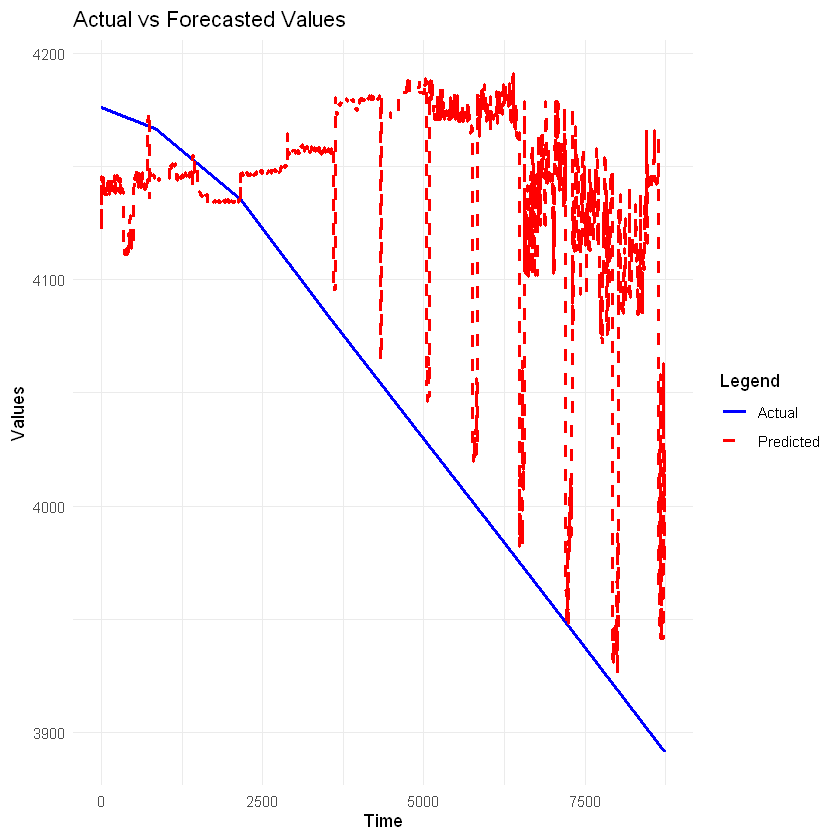

In [61]:
# Create a data frame for plotting
plot_data <- data.frame(
  Time = 1:length(T_test_XGB),  # Assuming sequential time indices
  Actual = T_test_XGB,
  Predicted = T_hat_t  # Your forecasted values
)


# Plot the actual vs. predicted values
ggplot(plot_data, aes(x = Time)) +
  geom_line(aes(y = Actual, color = "Actual"), size = 1) +
  geom_line(aes(y = Predicted, color = "Predicted"), size = 1, linetype = "dashed") +
  labs(title = "Actual vs Forecasted Values",
       x = "Time",
       y = "Values",
       color = "Legend") +
  theme_minimal() +
  scale_color_manual(values = c("Actual" = "blue", "Predicted" = "red"))

In [79]:
install.packages("patchwork")

package 'patchwork' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\madsh\AppData\Local\Temp\Rtmpsjay9t\downloaded_packages


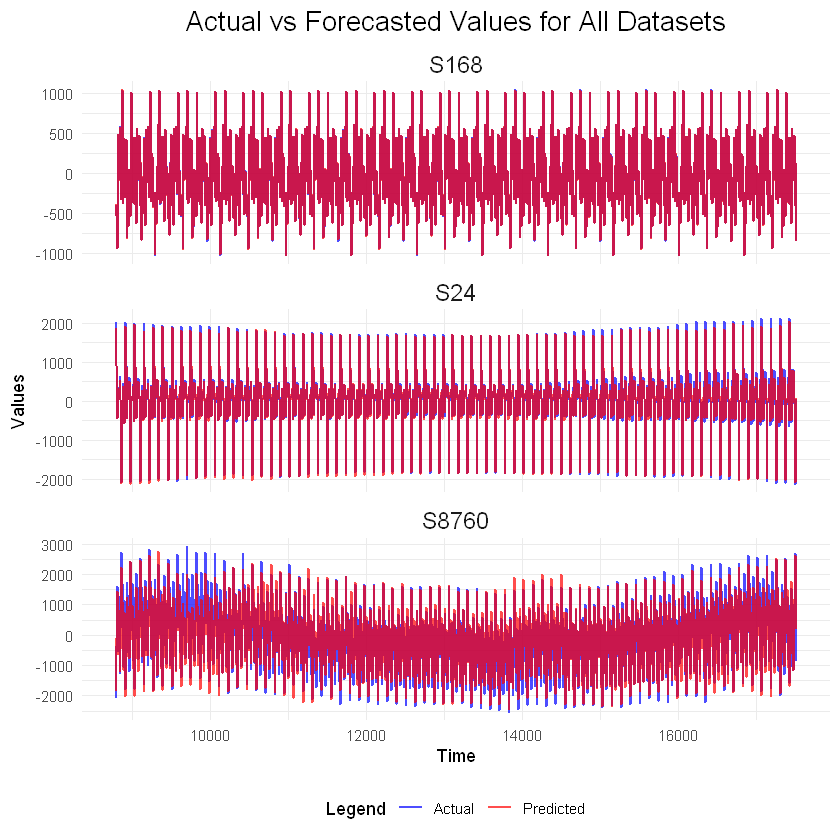

In [90]:
library(ggplot2)

# Combine all datasets into one data frame for faceting
combined_data <- do.call(rbind, lapply(names(results), function(dataset_name) {
  T_t <- datasets[[dataset_name]]$T_t
  T_hat_t <- results[[dataset_name]]
  time_indices <- seq(length(T_t) - length(T_hat_t) + 1, length(T_t))
  
  # Downsample data to reduce overplotting (adjust as needed)
  downsample_indices <- seq(1, length(time_indices), by = 10)
  data.frame(
    Time = time_indices[downsample_indices],
    Actual = T_t[time_indices[downsample_indices]],
    Predicted = T_hat_t[downsample_indices],
    Dataset = dataset_name
  )
}))

# Reshape for plotting
library(tidyr)
plot_data <- pivot_longer(combined_data, cols = c("Actual", "Predicted"),
                          names_to = "Type", values_to = "Value")

# Plot with facets
ggplot(plot_data, aes(x = Time, y = Value, color = Type)) +
  geom_line(size = 0.8, alpha = 0.7) +
  facet_wrap(~ Dataset, ncol = 1, scales = "free_y") +  # 3x1 layout with independent y-scales
  labs(title = "Actual vs Forecasted Values for All Datasets",
       x = "Time",
       y = "Values",
       color = "Legend") +
  theme_minimal() +
  scale_color_manual(values = c("Actual" = "blue", "Predicted" = "red")) +
  theme(strip.text = element_text(size = 14),  # Larger facet labels
        plot.title = element_text(hjust = 0.5, size = 16),
        legend.position = "bottom")


In [91]:
# Define the new folder path
path_S <- "C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Forecasting-energy-consumption/Data/Results/Boosting/S_hat"

# Loop through the results for each dataset and save them with unique names
for (dataset_name in names(results)) {
  # Generate the file name dynamically based on the dataset and parameters
  file_name_S_hat <- file.path(
    path_S,
    paste0(
      dataset_name,  # Add dataset name (e.g., S24, S168, S8760)
      "_h=", h,
      "_steps_ahead=", num_timesteps,
      "_nrounds=", nrounds,
      "_train_size=", train_size,
      "_XGB_S_hat_t.csv"
    )
  )
  
  # Save the result as a CSV file
  write.csv(results[[dataset_name]], file = file_name_S_hat, row.names = FALSE)
  
  # Print confirmation message
  cat(sprintf("Saved results for %s to %s\n", dataset_name, file_name_S_hat))
}

Saved results for S24 to C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Forecasting-energy-consumption/Data/Results/Boosting/S_hat/S24_h=8784_steps_ahead=720_nrounds=100_train_size=8784_XGB_S_hat_t.csv
Saved results for S168 to C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Forecasting-energy-consumption/Data/Results/Boosting/S_hat/S168_h=8784_steps_ahead=720_nrounds=100_train_size=8784_XGB_S_hat_t.csv
Saved results for S8760 to C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Forecasting-energy-consumption/Data/Results/Boosting/S_hat/S8760_h=8784_steps_ahead=720_nrounds=100_train_size=8784_XGB_S_hat_t.csv
